[View in Colaboratory](https://colab.research.google.com/github/Tzeny/cifar10/blob/master/Cifar10.ipynb)

This is my attempt at solving the Cifar10 challenge. This file is also available on GitHub: [https://github.com/Tzeny/cifar10/blob/master/Cifar10.ipynb](https://github.com/Tzeny/cifar10/blob/master/Cifar10.ipynb)



|Nr. crt.|Model architecture | Optimizer | Batch size  | Train images | Stop epoch | Test accuracy |
|---||------------- |---|-------------|----|
|1|2 x inception(w dr 3,36) 2 x (conv(144ft)+maxpool) flt 2 x dense (w dr) act \[w batch normalization\]|Adam(0.001)|128|Normalized color |~20|~93 %
|2|3 x inception(w dr 3, 36,216) (conv(288ft)+maxpool) flt 2 x dense (w dr) \[w batch normalization\]|Adam(0.001)|128|Normalized color|31|~91.11 %
|3|2 x inception(w dr 3,36) 2 x (conv(144ft)+maxpool) flt 2 x dense (w dr) act \[w batch normalization\]|Adam(0.001)|128|Normalized color |32|92.58 %
|5|3 x inception(w 3,36, GoogLeNet feature cnt) flt 2 x dense (w dr) act \[w batch normalization\]|Adam(0.001)|128|Normalized color |31|96.93 %

>[Google Colab ensure we have our own GPU](#scrollTo=nZ-oiI4YlXGL)

>[Connecting to Google Drive](#scrollTo=sqKMRov-lQjI)

>[Prepare our dataset](#scrollTo=l-LAEOiUmMgt)

>[Model definition and training](#scrollTo=xmoQDAurmSbS)

>[Model evaluation](#scrollTo=f53m3bg_p5rk)



# Google Colab ensure we have our own GPU

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /content/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /content/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 12.8 GB  | Proc size: 139.5 MB
GPU RAM Free: 11439MB | Used: 0MB | Util   0% | Total 11439MB


In [0]:
 !kill -9 -1

# Connecting to Google Drive

In [3]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p my_drive
!google-drive-ocamlfuse my_drive
!ls my_drive/ai


gpg: keybox '/tmp/tmp88mi_mqq/pubring.gpg' created
gpg: /tmp/tmp88mi_mqq/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 19804 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.6.21-0ubuntu2_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.6.21-0ubuntu2) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.6.2

# Prepare our dataset

In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(451)

from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

Using TensorFlow backend.


170500096/170498071 [==============================] - 21s 0us/step


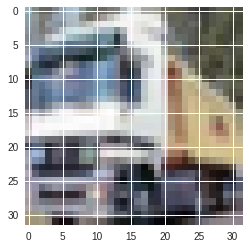

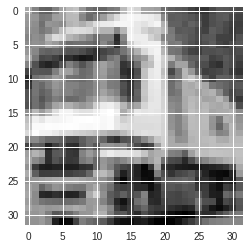

In [5]:
#gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
x_train_gray = np.dot(x_train[:,:,:,:3], [0.299, 0.587, 0.114])
x_test_gray = np.dot(x_test[:,:,:,:3], [0.299, 0.587, 0.114])

x_train_gray = x_train_gray.reshape(-1,32,32,1)
x_test_gray = x_test_gray.reshape(-1,32,32,1)

from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

plt.imshow(x_train[1])
plt.show()

plt.imshow(x_train_gray[1,:,:,0], cmap='gray')
plt.show()

# Model definition and training

In [15]:
np.random.seed(451)

import datetime

from keras.layers import Flatten, Activation, Conv2D, MaxPool2D, AvgPool2D, Dense, Dropout, BatchNormalization, Input, MaxPooling2D, Flatten, Activation, Conv2D, AvgPool2D, Dense, Dropout, concatenate, AveragePooling2D
from keras.optimizers import Adam, SGD
from keras.models import Sequential
import keras.backend as K
from keras.regularizers import l1,l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import model_from_json, Model

def build_tower(input_layer, features_nr, shape, tower_nr, 
                dropout=False, normalization=False, regularization="l2", dropout_ratio=0.25):
    #3x3 kernel tower
    tower = Conv2D(features_nr, (1,1), padding='same', activation='relu', 
                     kernel_regularizer=regularization, name='tower_%d_%dx%da'%(tower_nr, shape[0], shape[1]))(input_layer)
    tower = Conv2D(features_nr*2, shape, padding='same', activation='relu',
                     kernel_regularizer=regularization, name='tower_%d_%dx%db'%(tower_nr, shape[0], shape[1]))(tower)
    #condidional dropout/normalization
    if dropout:
        tower = Dropout(dropout_ratio, name='tower_%d_%dx%ddrop'%(tower_nr, shape[0], shape[1]))(tower)
    if normalization:
        tower = BatchNormalization(name='tower_%d_%dx%dnorm'%(tower_nr, shape[0], shape[1]))(tower)
        
    return tower

def build_simple_tower(input_layer, features_nr, shape, tower_nr, 
                dropout=False, normalization=False, regularization="l2", dropout_ratio=0.25):
    #3x3 kernel tower
    tower = Conv2D(features_nr, shape, padding='same', activation='relu',
                     kernel_regularizer=regularization, 
                   name='tower_simple_%d_%dx%db'%(tower_nr, shape[0], shape[1]))(input_layer)
    #condidional dropout/normalization
    if dropout:
        tower = Dropout(dropout_ratio, name='tower_%d_%dx%ddrop'%(tower_nr, shape[0], shape[1]))(tower)
    if normalization:
        tower = BatchNormalization(name='tower_%d_%dx%dnorm'%(tower_nr, shape[0], shape[1]))(tower)
        
    return tower

def build_tower_subsample(input_layer, features_nr, shape, tower_nr, 
                          dropout=False, normalization=False, regularization='l2', dropout_ratio=0.25):
    tower = build_tower(input_layer, features_nr, shape, tower_nr, 
                        dropout, normalization, regularization, dropout_ratio)
    pool = MaxPooling2D((2,2), padding='same', name='tower_%d_2x2subsample'%(tower_nr))(tower)

    return pool

def build_simple_tower_subsample(input_layer, features_nr, shape, tower_nr, 
                          dropout=False, normalization=False, regularization='l2', dropout_ratio=0.25):
    tower = build_simple_tower(input_layer, features_nr, shape, tower_nr, 
                        dropout, normalization, regularization, dropout_ratio)
    pool = MaxPooling2D((2,2), padding='same', name='tower_%d_2x2subsample'%(tower_nr))(tower)

    return pool

def build_dense(input_layer, neurons_nr, dense_nr, 
                dropout=False, normalization=False, regularization='l2', dropout_ratio=0.5):
    dense = Dense(neurons_nr, kernel_regularizer=regularization, 
                  name='dense_%d_%d'%(dense_nr, neurons_nr))(input_layer)
    
    if dropout:
        dense = Dropout(dropout_ratio, name='dense_%d_%ddrop'%(dense_nr, neurons_nr))(dense)
    if normalization:
        dense = BatchNormalization(name='dense_%d_%dnorm'%(dense_nr, neurons_nr))(dense)
    
    return dense

def build_inception_module(input_layer, features_nr, module_nr, 
                           dropout=False, normalization=False, regularization='l2', dropout_ratio=0.2):  
    #feature_nr is an array we'll use to build our layers
    #data is in the form: [1x1, 3x3 reduce, 3x3, 5x5 reduce, 5x5, pool proj]
  
    inception_1x1 = Conv2D(features_nr[0],1,1,border_mode='same',activation='relu',name='inception_%d_/1x1'%(module_nr),W_regularizer=l2(0.0002))(input_layer)
    
    inception_3x3_reduce = Conv2D(features_nr[1],1,1,border_mode='same',activation='relu',name='inception_%d_/3x3_reduce'%(module_nr),W_regularizer=l2(0.0002))(input_layer)
    
    inception_3x3 = Conv2D(features_nr[2],3,3,border_mode='same',activation='relu',name='inception_%d_/3x3'%(module_nr),W_regularizer=l2(0.0002))(inception_3x3_reduce)
    
    inception_5x5_reduce = Conv2D(features_nr[3],1,1,border_mode='same',activation='relu',name='inception_%d_/5x5_reduce'%(module_nr),W_regularizer=l2(0.0002))(input_layer)
    
    inception_5x5 = Conv2D(features_nr[4],5,5,border_mode='same',activation='relu',name='inception_%d_/5x5'%(module_nr),W_regularizer=l2(0.0002))(inception_5x5_reduce)
    
    inception_pool = MaxPooling2D(pool_size=(3,3),strides=(1,1),border_mode='same',name='inception_%d_/pool'%(module_nr))(input_layer)
    
    inception_pool_proj = Conv2D(features_nr[5],1,1,border_mode='same',activation='relu',name='inception_%d_/pool_proj'%(module_nr),W_regularizer=l2(0.0002))(inception_pool)
    
    inception_output = concatenate([inception_1x1,inception_3x3,inception_5x5,inception_pool_proj],axis=3,name='inception_%d_/output'%(module_nr))

    if dropout:
        inception_output = Dropout(dropout_ratio, name='inception_%d_/output_drop'%(module_nr))(inception_output)
    if normalization:
        inception_output = BatchNormalization(name='inception_%d_/output_norm'%(module_nr))(inception_output)

    pooled = MaxPooling2D((2,2), padding='same', name='inception_%d_2x2subsample'%(module_nr))(inception_output)
    
    return pooled

i='cifar10-nrcrt6-'+datetime.datetime.now().strftime("%I:%M%p_%B-%d-%Y")

K.clear_session()

!mkdir -p models
!mkdir -p logs

a = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')#will stop the model if val_loss does not improve for 2 consecutive epochs
b = ModelCheckpoint(monitor='val_loss', filepath='./models/'+str(i)+'.hdf5', verbose=1, save_best_only=True)#save model weights after each epoch if val_loss improves
c = TensorBoard(log_dir='./logs/'+str(i),
                write_grads=True,
                write_graph=True,
                write_images=True,
                batch_size=128)#saves a log file for tensorboard; remember to save different runs to different subdirectories

#we'll use this instead of decay
d = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[a,b,c,d]

#------------model definition-------------------

use_norm = True
lrate = 0.001

input_img = Input(shape = (32, 32, 3), name='input')

#conv_1 = Conv2D(1, (1,1), padding='same', activation='relu', 
               # kernel_regularizer = regularization, name='conv_64x64x1_inception_in')(input_img)

#hopefully this will learn a good internal representation of the image channels
#conv_1 = Conv2D(1, (1,1), padding='same', activation='relu', 
                #kernel_regularizer = regularization, name='conv_64x64x1_inception_in')(input_img)

inception_1 = build_inception_module(input_img, [64,96,128,16,32,32], 1, False, use_norm)

inception_2 = build_inception_module(inception_1, [128,128,192,32,96,64], 2, False, use_norm)

inception_3 = build_inception_module(inception_2, [192,96,208,16,48,64], 3, False, use_norm)
#tower_3 = build_simple_tower(inception_2, 144, (3,3),  3, False, use_norm)
#tower_4 = build_simple_tower_subsample(tower_3, 144, (3,3), 4, False, use_norm)

#tower_5 = build_simple_tower(tower_4, 288, (3,3),  5, False, use_norm)
#tower_6 = build_simple_tower_subsample(tower_5, 288, (3,3), 6, False, use_norm)

#model top

flat_pool = AveragePooling2D(pool_size=(4, 4), padding='valid')(inception_3)

flat = Flatten()(flat_pool)


dense_5 = build_dense(flat, 128, 1, True, use_norm)

dense_6 = build_dense(dense_5, 64, 2, True, use_norm)

out = Dense(10, activation='softmax')(dense_6)

model = Model(inputs = input_img, outputs = out)

#-----------------------------------------------

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lrate),
              metrics=['accuracy'])

model.summary()

model_json = model.to_json()
with open("./models/"+str(i)+".json", "w") as json_file:
    json_file.write(model_json)

print("Saved model to" + "../models/"+str(i)+".json")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), activation="relu", name="inception_1_/1x1", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (1, 1), activation="relu", name="inception_1_/3x3_reduce", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="inception_1_/3x3", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1), activation="relu", name="inception_1_/5x5_reduce", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
inception_1_/3x3_reduce (Conv2D (None, 32, 32, 96)   384         input[0][0]                      
__________________________________________________________________________________________________
inception_1_/5x5_reduce (Conv2D (None, 32, 32, 16)   64          input[0][0]                      
__________________________________________________________________________________________________
inception_1_/pool (MaxPooling2D (None, 32, 32, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
inception_

In [16]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes
  
print("Memory usage (GB):", get_model_memory_usage(128,model))

Memory usage (GB): 1.237


In [17]:
import tensorflow as tf

with tf.device('/gpu:0'):
  model.fit(x_train, y_train_cat, batch_size=128, epochs=100, validation_split=0.2,verbose=1,callbacks=callbacks)  # starts training

result = model.evaluate(x_test, y_test_cat)

print("Accuracy on test set: ",result[1]*100,"%")

#copy our generated model and logs to GoogleDrive
!cp -R models my_drive/ai/projects/cifar10
!cp -R logs my_drive/ai/projects/cifar10

print("Copied model and logs to Google Drive")

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 73s 2ms/step - loss: 0.8715 - acc: 0.9053 - val_loss: 0.3898 - val_acc: 0.9034

Epoch 00001: val_loss improved from inf to 0.38979, saving model to ./models/cifar10-nrcrt5-06:35AM_July-11-2018.hdf5
Epoch 2/100
13440/40000 [=========>....................] - ETA: 42s - loss: 0.3199 - acc: 0.9235

40000/40000 [==============================] - 69s 2ms/step - loss: 0.2907 - acc: 0.9272 - val_loss: 0.3650 - val_acc: 0.9056

Epoch 00002: val_loss improved from 0.38979 to 0.36498, saving model to ./models/cifar10-nrcrt5-06:35AM_July-11-2018.hdf5
Epoch 3/100
25984/40000 [==================>...........] - ETA: 22s - loss: 0.2443 - acc: 0.9364

40000/40000 [==============================] - 69s 2ms/step - loss: 0.2411 - acc: 0.9370 - val_loss: 0.2978 - val_acc: 0.9140

Epoch 00003: val_loss improved from 0.36498 to 0.29782, saving model to ./models/cifar10-nrcrt5-06:35AM_July-11-2018.hdf5
Epoch 4/100
29312/40000 [====================>.........] - ETA: 16s - loss: 0.2202 - acc: 0.9420

40000/40000 [==============================] - 69s 2ms/step - loss: 0.2192 - acc: 0.9422 - val_loss: 0.2565 - val_acc: 0.9267

Epoch 00004: val_loss improved from 0.29782 to 0.25653, saving model to ./models/cifar10-nrcrt5-06:35AM_July-11-2018.hdf5
Epoch 5/100
30208/40000 [=====================>........] - ETA: 15s - loss: 0.2046 - acc: 0.9467

40000/40000 [==============================] - 69s 2ms/step - loss: 0.2056 - acc: 0.9464 - val_loss: 0.2707 - val_acc: 0.9276

Epoch 00005: val_loss did not improve from 0.25653
Epoch 6/100
37120/40000 [==========================>...] - ETA: 4s - loss: 0.1969 - acc: 0.9497

40000/40000 [==============================] - 69s 2ms/step - loss: 0.1966 - acc: 0.9498 - val_loss: 0.4357 - val_acc: 0.8652

Epoch 00006: val_loss did not improve from 0.25653
Epoch 7/100
39168/40000 [============================>.] - ETA: 1s - loss: 0.1895 - acc: 0.9529

40000/40000 [==============================] - 69s 2ms/step - loss: 0.1896 - acc: 0.9528 - val_loss: 0.2241 - val_acc: 0.9379

Epoch 00007: val_loss improved from 0.25653 to 0.22405, saving model to ./models/cifar10-nrcrt5-06:35AM_July-11-2018.hdf5
Epoch 8/100
31104/40000 [======================>.......] - ETA: 14s - loss: 0.1826 - acc: 0.9547

40000/40000 [==============================] - 69s 2ms/step - loss: 0.1826 - acc: 0.9546 - val_loss: 0.2131 - val_acc: 0.9407

Epoch 00008: val_loss improved from 0.22405 to 0.21315, saving model to ./models/cifar10-nrcrt5-06:35AM_July-11-2018.hdf5
Epoch 9/100
28928/40000 [====================>.........] - ETA: 17s - loss: 0.1746 - acc: 0.9584

40000/40000 [==============================] - 69s 2ms/step - loss: 0.1755 - acc: 0.9578 - val_loss: 0.2915 - val_acc: 0.9201

Epoch 00009: val_loss did not improve from 0.21315
Epoch 10/100
34944/40000 [=========================>....] - ETA: 7s - loss: 0.1701 - acc: 0.9598

40000/40000 [==============================] - 69s 2ms/step - loss: 0.1709 - acc: 0.9596 - val_loss: 0.2710 - val_acc: 0.9248

Epoch 00010: val_loss did not improve from 0.21315
Epoch 11/100
38656/40000 [===========================>..] - ETA: 2s - loss: 0.1689 - acc: 0.9599

40000/40000 [==============================] - 69s 2ms/step - loss: 0.1690 - acc: 0.9599 - val_loss: 0.2003 - val_acc: 0.9491

Epoch 00011: val_loss improved from 0.21315 to 0.20027, saving model to ./models/cifar10-nrcrt5-06:35AM_July-11-2018.hdf5
Epoch 12/100
32000/40000 [=======================>......] - ETA: 12s - loss: 0.1650 - acc: 0.9617

40000/40000 [==============================] - 69s 2ms/step - loss: 0.1649 - acc: 0.9616 - val_loss: 0.1748 - val_acc: 0.9570

Epoch 00012: val_loss improved from 0.20027 to 0.17482, saving model to ./models/cifar10-nrcrt5-06:35AM_July-11-2018.hdf5
Epoch 13/100
27904/40000 [===================>..........] - ETA: 19s - loss: 0.1588 - acc: 0.9638

40000/40000 [==============================] - 69s 2ms/step - loss: 0.1599 - acc: 0.9635 - val_loss: 0.1975 - val_acc: 0.9468

Epoch 00013: val_loss did not improve from 0.17482
Epoch 14/100
33152/40000 [=======================>......] - ETA: 10s - loss: 0.1565 - acc: 0.9647

40000/40000 [==============================] - 69s 2ms/step - loss: 0.1576 - acc: 0.9644 - val_loss: 0.2465 - val_acc: 0.9344

Epoch 00014: val_loss did not improve from 0.17482
Epoch 15/100
37504/40000 [===========================>..] - ETA: 3s - loss: 0.1555 - acc: 0.9654

40000/40000 [==============================] - 69s 2ms/step - loss: 0.1559 - acc: 0.9652 - val_loss: 0.1816 - val_acc: 0.9570

Epoch 00015: val_loss did not improve from 0.17482
Epoch 16/100
35840/40000 [=========================>....] - ETA: 6s - loss: 0.1539 - acc: 0.9661

40000/40000 [==============================] - 69s 2ms/step - loss: 0.1540 - acc: 0.9660 - val_loss: 0.2039 - val_acc: 0.9476

Epoch 00016: val_loss did not improve from 0.17482
Epoch 17/100
36736/40000 [==========================>...] - ETA: 5s - loss: 0.1499 - acc: 0.9672

40000/40000 [==============================] - 69s 2ms/step - loss: 0.1508 - acc: 0.9669 - val_loss: 0.2528 - val_acc: 0.9338

Epoch 00017: val_loss did not improve from 0.17482
Epoch 18/100
36480/40000 [==========================>...] - ETA: 5s - loss: 0.1226 - acc: 0.9769

40000/40000 [==============================] - 69s 2ms/step - loss: 0.1218 - acc: 0.9771 - val_loss: 0.1375 - val_acc: 0.9686

Epoch 00018: val_loss improved from 0.17482 to 0.13747, saving model to ./models/cifar10-nrcrt5-06:35AM_July-11-2018.hdf5
Epoch 19/100


40000/40000 [==============================] - 69s 2ms/step - loss: 0.1039 - acc: 0.9815 - val_loss: 0.1327 - val_acc: 0.9685

Epoch 00019: val_loss improved from 0.13747 to 0.13273, saving model to ./models/cifar10-nrcrt5-06:35AM_July-11-2018.hdf5
Epoch 20/100
27776/40000 [===================>..........] - ETA: 19s - loss: 0.0941 - acc: 0.9840

40000/40000 [==============================] - 69s 2ms/step - loss: 0.0938 - acc: 0.9839 - val_loss: 0.1288 - val_acc: 0.9692

Epoch 00020: val_loss improved from 0.13273 to 0.12875, saving model to ./models/cifar10-nrcrt5-06:35AM_July-11-2018.hdf5
Epoch 21/100
27648/40000 [===================>..........] - ETA: 19s - loss: 0.0864 - acc: 0.9858

40000/40000 [==============================] - 69s 2ms/step - loss: 0.0862 - acc: 0.9856 - val_loss: 0.1271 - val_acc: 0.9686

Epoch 00021: val_loss improved from 0.12875 to 0.12707, saving model to ./models/cifar10-nrcrt5-06:35AM_July-11-2018.hdf5
Epoch 22/100
27008/40000 [===================>..........] - ETA: 20s - loss: 0.0810 - acc: 0.9868

40000/40000 [==============================] - 69s 2ms/step - loss: 0.0807 - acc: 0.9869 - val_loss: 0.1273 - val_acc: 0.9683

Epoch 00022: val_loss did not improve from 0.12707
Epoch 23/100
32768/40000 [=======================>......] - ETA: 11s - loss: 0.0757 - acc: 0.9886

40000/40000 [==============================] - 69s 2ms/step - loss: 0.0755 - acc: 0.9885 - val_loss: 0.1305 - val_acc: 0.9676

Epoch 00023: val_loss did not improve from 0.12707
Epoch 24/100
35584/40000 [=========================>....] - ETA: 6s - loss: 0.0711 - acc: 0.9900

40000/40000 [==============================] - 69s 2ms/step - loss: 0.0712 - acc: 0.9898 - val_loss: 0.1341 - val_acc: 0.9667

Epoch 00024: val_loss did not improve from 0.12707
Epoch 25/100
38400/40000 [===========================>..] - ETA: 2s - loss: 0.0660 - acc: 0.9916

40000/40000 [==============================] - 69s 2ms/step - loss: 0.0660 - acc: 0.9915 - val_loss: 0.1325 - val_acc: 0.9679

Epoch 00025: val_loss did not improve from 0.12707
Epoch 26/100
38400/40000 [===========================>..] - ETA: 2s - loss: 0.0625 - acc: 0.9925

40000/40000 [==============================] - 69s 2ms/step - loss: 0.0625 - acc: 0.9925 - val_loss: 0.1329 - val_acc: 0.9676

Epoch 00026: val_loss did not improve from 0.12707
Epoch 27/100
38784/40000 [============================>.] - ETA: 1s - loss: 0.0571 - acc: 0.9946

40000/40000 [==============================] - 69s 2ms/step - loss: 0.0572 - acc: 0.9945 - val_loss: 0.1316 - val_acc: 0.9681

Epoch 00027: val_loss did not improve from 0.12707
Epoch 28/100
39296/40000 [============================>.] - ETA: 1s - loss: 0.0558 - acc: 0.9950

40000/40000 [==============================] - 69s 2ms/step - loss: 0.0558 - acc: 0.9951 - val_loss: 0.1321 - val_acc: 0.9682

Epoch 00028: val_loss did not improve from 0.12707
Epoch 29/100
38272/40000 [===========================>..] - ETA: 2s - loss: 0.0551 - acc: 0.9952

40000/40000 [==============================] - 69s 2ms/step - loss: 0.0551 - acc: 0.9952 - val_loss: 0.1325 - val_acc: 0.9682

Epoch 00029: val_loss did not improve from 0.12707
Epoch 30/100
37376/40000 [===========================>..] - ETA: 4s - loss: 0.0541 - acc: 0.9956

40000/40000 [==============================] - 69s 2ms/step - loss: 0.0542 - acc: 0.9955 - val_loss: 0.1330 - val_acc: 0.9682

Epoch 00030: val_loss did not improve from 0.12707
Epoch 31/100
37632/40000 [===========================>..] - ETA: 3s - loss: 0.0533 - acc: 0.9958

40000/40000 [==============================] - 69s 2ms/step - loss: 0.0532 - acc: 0.9958 - val_loss: 0.1340 - val_acc: 0.9679

Epoch 00031: val_loss did not improve from 0.12707
Epoch 00031: early stopping
10000/10000 [==============================] - 8s 843us/step
Accuracy on test set:  96.7410002708435 %
Copied model and logs to Google Drive


# Model evaluation

In [18]:
model.load_weights('./models/cifar10-nrcrt5-06:35AM_July-11-2018.hdf5')

result = model.evaluate(x_test, y_test_cat)

print(result)

10000/10000 [==============================] - 8s 825us/step
[0.12818889632225036, 0.9693300001144409]
